# cifar10用のresnetを用いたbyolの学習と評価
参考code <br>
BYOL: https://github.com/Spijkervet/BYOL<br>
Resnet: https://github.com/kuangliu/pytorch-cifar

### moduleの読み込み

In [46]:
import os
import argparse
import copy
import random
from functools import wraps
import numpy as np
from collections import defaultdict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from sklearn.neighbors import KNeighborsClassifier

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import models, datasets

# distributed training
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

### モデルの定義

In [2]:
"""
MIT License

Copyright (c) 2020 Phil Wang
https://github.com/lucidrains/byol-pytorch/

Adjusted to de-couple for data loading, parallel training
"""

# helper functions


def default(val, def_val):
    return def_val if val is None else val


def flatten(t):
    return t.reshape(t.shape[0], -1)


def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance

        return wrapper

    return inner_fn


# loss fn


def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)


# augmentation utils


class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)


# exponential moving average


class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new


def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(
        current_model.parameters(), ma_model.parameters()
    ):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)


# MLP class for projector and predictor


class MLP(nn.Module):
    def __init__(self, dim, projection_size, hidden_size=4096):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size),
        )

    def forward(self, x):
        return self.net(x)


# a wrapper class for the base neural network
# will manage the interception of the hidden layer output
# and pipe it into the projecter and predictor nets


class NetWrapper(nn.Module):
    def __init__(self, net, projection_size, projection_hidden_size, layer=-2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.projector = None
        self.projection_size = projection_size
        self.projection_hidden_size = projection_hidden_size

        self.hidden = None
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, __, output):
        self.hidden = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f"hidden layer ({self.layer}) not found"
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton("projector")
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        projector = MLP(dim, self.projection_size, self.projection_hidden_size)
        return projector.to(hidden)

    def get_representation(self, x):
        if not self.hook_registered:
            self._register_hook()

        if self.layer == -1:
            return self.net(x)

        _ = self.net(x)
        hidden = self.hidden
        self.hidden = None
        assert hidden is not None, f"hidden layer {self.layer} never emitted an output"
        return hidden

    def forward(self, x):
        representation = self.get_representation(x)
        projector = self._get_projector(representation)
        projection = projector(representation)
        return projection


# main class


class BYOL(nn.Module):
    def __init__(
        self,
        net,
        image_size,
        hidden_layer=-2,
        projection_size=256,
        projection_hidden_size=4096,
        augment_fn=None,
        moving_average_decay=0.99,
    ):
        super().__init__()

        self.online_encoder = NetWrapper(
            net, projection_size, projection_hidden_size, layer=hidden_layer
        )
        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)

        self.online_predictor = MLP(
            projection_size, projection_size, projection_hidden_size
        )

        # send a mock image tensor to instantiate singleton parameters
        self.forward(torch.randn(2, 3, image_size, image_size), torch.randn(2, 3, image_size, image_size))

    @singleton("target_encoder")
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        return target_encoder

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_moving_average(self):
        assert (
            self.target_encoder is not None
        ), "target encoder has not been created yet"
        update_moving_average(
            self.target_ema_updater, self.target_encoder, self.online_encoder
        )

    def forward(self, image_one, image_two):
        online_proj_one = self.online_encoder(image_one)
        online_proj_two = self.online_encoder(image_two)

        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)

        with torch.no_grad():
            target_encoder = self._get_target_encoder()
            target_proj_one = target_encoder(image_one)
            target_proj_two = target_encoder(image_two)

        loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        loss_two = loss_fn(online_pred_two, target_proj_one.detach())

        loss = loss_one + loss_two
        return loss.mean()

In [3]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):#################
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)###########################
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = F.avg_pool2d(out, 4)#################
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

### data拡張

In [4]:
class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly 
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size=size),
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

## train

### parameter設定

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--image_size", default=32, type=int, help="Image size")
parser.add_argument(
    "--learning_rate", default=3e-4, type=float, help="Initial learning rate."
)
parser.add_argument(
    "--batch_size", default=192, type=int, help="Batch size for training."
)
parser.add_argument(
    "--num_epochs", default=1000, type=int, help="Number of epochs to train for."
)
parser.add_argument(
    "--resnet_version", default="resnet18", type=str, help="ResNet version."
)
parser.add_argument(
    "--checkpoint_epochs",
    default=50,
    type=int,
    help="Number of epochs between checkpoints/summaries.",
)
parser.add_argument(
    "--dataset_dir",
    default="./datasets",
    type=str,
    help="Directory where dataset is stored.",
)
parser.add_argument(
    "--num_workers",
    default=8,
    type=int,
    help="Number of data loading workers (caution with nodes!)",
)
parser.add_argument(
    "--nodes", default=1, type=int, help="Number of nodes",
)
parser.add_argument("--gpus", default=1, type=int, help="number of gpus per node")
parser.add_argument("--nr", default=0, type=int, help="ranking within the nodes")
parser.add_argument("--cuda", default="cuda:0", type=str, help="cuda number")
parser.add_argument("--seed", default=0, type=int, help="number of seed")

# colab work-around
# args = parser.parse_args()
args = parser.parse_args(args=[])

### train dataset

In [6]:
train_dataset = datasets.CIFAR10(
    args.dataset_dir,
    download=True,
    transform=TransformsSimCLR(size=args.image_size), # paper 224
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    drop_last=True,
    num_workers=args.num_workers,
)

Files already downloaded and verified


### モデルの学習

In [ ]:
device = torch.device(args.cuda) if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(args.seed)

resnet = ResNet18()

model = BYOL(resnet, image_size=args.image_size, hidden_layer="avgpool")
model = model.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

# solver
global_step = 0

for epoch in range(args.num_epochs+1):
    metrics = defaultdict(list)
    start = time.time()
    
    with open('log_train_loss.txt', 'a') as f:
        f.write(f"{epoch}Epoch start\n")
    
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        x_i = x_i.to(device)
        x_j = x_j.to(device)

        loss = model(x_i, x_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.update_moving_average()  # update moving average of target encoder

        if step % 1 == 0:
            with open('log_train_loss.txt', 'a') as f:
                f.write(f"Step [{step}/{len(train_loader)}]:\tLoss: {loss.item()}\n")
            #print(f"Step [{step}/{len(train_loader)}]:\tLoss: {loss.item()}")

        metrics["Loss/train"].append(loss.item())
        global_step += 1

    # write metrics to TensorBoard
    epoch_time = time.time() - start
    print(f"Epoch [{epoch}/{args.num_epochs}]: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()])  + f"\ttime:{epoch_time}")
    
    with open('log_train_epoch_loss.txt', 'a') as f:
        f.write(f"Epoch [{epoch}/{args.num_epochs}]: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()])  + f"\ttime:{epoch_time}\n")

    if epoch % args.checkpoint_epochs == 0:
        print(f"Saving model at epoch {epoch}")
        torch.save(resnet.state_dict(), f"./model-{epoch}.pt")

# save your improved network
torch.save(resnet.state_dict(), "./model-final.pt")

Step [0/260]:	Loss: 3.961852788925171
Step [1/260]:	Loss: 2.469606637954712
Step [2/260]:	Loss: 2.0464189052581787
Step [3/260]:	Loss: 1.9024022817611694
Step [4/260]:	Loss: 1.8080511093139648
Step [5/260]:	Loss: 1.8205604553222656
Step [6/260]:	Loss: 1.7964218854904175
Step [7/260]:	Loss: 1.7622851133346558
Step [8/260]:	Loss: 1.7911841869354248
Step [9/260]:	Loss: 1.7791122198104858
Step [10/260]:	Loss: 1.78219735622406
Step [11/260]:	Loss: 1.8013203144073486
Step [12/260]:	Loss: 1.8329315185546875
Step [13/260]:	Loss: 1.8023478984832764
Step [14/260]:	Loss: 1.8147344589233398
Step [15/260]:	Loss: 1.8062710762023926
Step [16/260]:	Loss: 1.809901237487793
Step [17/260]:	Loss: 1.7953367233276367
Step [18/260]:	Loss: 1.8214950561523438
Step [19/260]:	Loss: 1.8240258693695068
Step [20/260]:	Loss: 1.8194353580474854
Step [21/260]:	Loss: 1.810143232345581
Step [22/260]:	Loss: 1.8085260391235352
Step [23/260]:	Loss: 1.8486522436141968
Step [24/260]:	Loss: 1.846562385559082
Step [25/260]:	Lo

## eval

### 関数の定義

In [ ]:
def inference(loader, model, device):
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)

        # get encoding
        with torch.no_grad():
            h = model(x)

        h = h.squeeze()
        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        # if step % 5 == 0:
        #     print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    # print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

def get_features(model, train_loader, test_loader, device):
    train_X, train_y = inference(train_loader, model, device)
    test_X, test_y = inference(test_loader, model, device)
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

### parameter設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--image_size", default=32, type=int, help="Image size")
parser.add_argument(
    "--learning_rate", default=3e-3, type=float, help="Initial learning rate."
)
parser.add_argument(
    "--batch_size", default=768, type=int, help="Batch size for training."
)
parser.add_argument(
    "--num_epochs", default=300, type=int, help="Number of epochs to linear train for."
)
parser.add_argument(
    "--saved_checkpoint_epochs", default=50, type=int, help="checkpoint epoch set at the time of learning"
)
parser.add_argument(
    "--saved_epoch", default=1000, type=int, help="Saved model max epoch."
)
parser.add_argument(
    "--checkpoint_epochs",
    default=10,
    type=int,
    help="Number of epochs between checkpoints/summaries.",
)
parser.add_argument(
    "--dataset_dir",
    default="./datasets",
    type=str,
    help="Directory where dataset is stored.",
)
parser.add_argument(
    "--num_workers",
    default=8,
    type=int,
    help="Number of data loading workers (caution with nodes!)",
)
parser.add_argument("--cuda", default="cuda:0", type=str, help="cuda number")
parser.add_argument("--seed", default=0, type=int, help="number of seed")
parser.add_argument("--k", default=15, type=int, help="k of knn")

args = parser.parse_args(args=[])

args.model_path = "model-final.pt"

### eval dataset

In [ ]:
train_dataset = datasets.CIFAR10(
    args.dataset_dir,
    download=True,
    transform=TransformsSimCLR(size=args.image_size).test_transform,
)

test_dataset = datasets.CIFAR10(
    args.dataset_dir,
    train=False,
    download=True,
    transform=TransformsSimCLR(size=args.image_size).test_transform,
)

Train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    drop_last=True,
    num_workers=args.num_workers,
)

Test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    drop_last=True,
    num_workers=args.num_workers,
)

### 線形分類器とknnの学習と評価
modelの学習時に保存したモデルの数読み込む。<br>
例）学習時に1000epoch回して、50epochごとに保存したならば20個のモデルが存在するので、20回読み込み評価する。(変更したいのならargsを変える)

In [ ]:
device = torch.device(args.cuda) if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(args.seed)

epoch_linear_test_acc = []
epoch_knn_test_acc = []
result_df = pd.DataFrame(columns=["Linear Acc", "K-NN Acc"])

num_models = args.saved_epoch // args.saved_checkpoint_epochs

for i in tqdm(range(num_models+1)):
    # pre-trained model
    resnet = ResNet18()
    resnet.load_state_dict(torch.load(f"model-{i*args.saved_checkpoint_epochs}.pt", map_location=device))
    resnet = resnet.to(device)

    num_features = list(resnet.children())[-1].in_features

    # throw away fc layer
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    n_classes = 10 # CIFAR-10 has 10 classes

    # fine-tune model
    logreg = nn.Sequential(nn.Linear(num_features, n_classes))
    logreg = logreg.to(device)

    # loss / optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=logreg.parameters(), lr=args.learning_rate)
    
    if not os.path.exists(f"features_{i*args.saved_checkpoint_epochs}.p"):
        print("### Creating features from pre-trained model ###")
        (train_X, train_y, test_X, test_y) = get_features(
            resnet, Train_loader, Test_loader, device
        )
        pickle.dump(
            (train_X, train_y, test_X, test_y), open(f"features_{i*args.saved_checkpoint_epochs}.p", "wb"), protocol=4
        )
    else:
        print("### Loading features ###")
        (train_X, train_y, test_X, test_y) = pickle.load(open(f"features_{i*args.saved_checkpoint_epochs}.p", "rb"))


    train_loader, test_loader = create_data_loaders_from_arrays(
        train_X, train_y, test_X, test_y, 2048 
    )
    
    #eval_train----------------------------------------------------------------------------------------------
    #linear
    for epoch in range(args.num_epochs):
        for step, (h, y) in enumerate(train_loader):
            h = h.to(device)
            y = y.to(device)

            outputs = logreg(h)

            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #accuracyの計算はぶく
    #knn        
    knn = KNeighborsClassifier(n_neighbors=args.k)
    knn.fit(train_X, train_y)
    #--------------------------------------------------------------------------------------------------------
    
    #eval_test-----------------------------------------------------------------------------------------------
    #linear
    metrics = defaultdict(list)
    for step, (h, y) in enumerate(test_loader):
        h = h.to(device)
        y = y.to(device)

        outputs = logreg(h)

        # calculate accuracy and save metrics
        linear_acc = (outputs.argmax(1) == y).sum().item() / y.size(0)
        metrics["Accuracy/linear"].append(linear_acc)
    #knn
    pred_labels = knn.predict(test_X)
    knn_acc = sum(pred_labels == test_y)/len(test_y)
    #--------------------------------------------------------------------------------------------------------
    
    #結果の表示と保存
    print(f"[{i*args.saved_checkpoint_epochs}epoch] " + "\t".join([f"{k}: {np.array(v).mean():.4}" for k, v in metrics.items()])
         + "\t"f"Accuracy/knn: {knn_acc:.4}")
    
    with open('log_test_acc.txt', 'a') as f:
        f.write(f"[{i*args.saved_checkpoint_epochs}epoch] " + "\t".join([f"{k}: {np.array(v).mean():.4}" for k, v in metrics.items()])
         + "\t"f"Accuracy/knn: {knn_acc:.4}\n")
    
    result_df.loc[i*args.saved_checkpoint_epochs, "Linear Acc"] = np.array(metrics["Accuracy/linear"]).mean()
    result_df.loc[i*args.saved_checkpoint_epochs, "K-NN Acc"] = knn_acc

    epoch_linear_test_acc.append(np.array(metrics["Accuracy/linear"]).mean())
    epoch_knn_test_acc.append(knn_acc)
    
result_df.to_csv("./result_df.csv", index=False)

  0%|                                                    | 0/21 [00:00<?, ?it/s]

### Loading features ###


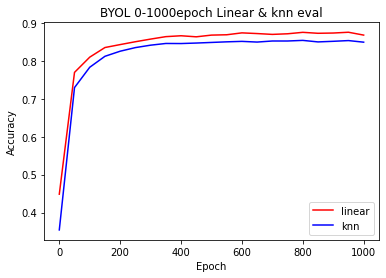

In [14]:
plt.figure()
plt.title("BYOL 0-1000epoch Linear & knn eval")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0, 1050, 50),epoch_linear_test_acc, color='red',linestyle='-', label="linear")
plt.plot(range(0, 1050, 50),epoch_knn_test_acc, color='blue',linestyle='-', label="knn")
plt.legend()
plt.savefig("BYOL 0-1000epoch Linear & knn eval")
plt.show()

In [51]:
df = pd.read_csv("./result_df.csv")
df

,Linear Acc,K-NN Acc
0,0.448479,0.354167
1,0.769545,0.729768
2,0.810296,0.783353
3,0.835226,0.812300
4,0.843248,0.825721
5,0.851242,0.835236
6,0.858426,0.841647
7,0.863616,0.846154
8,0.865695,0.845954
9,0.863518,0.847256
